In [51]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [53]:
words = open("names.txt", "r").read()
print(words[:10])

emma
olivi


In [54]:
def make_encoder_decoder(words: list[str]) -> tuple[dict[str, int], dict[int, str]]:
    letters = sorted(set("".join(words)))
    encoder = {letter: i for i, letter in enumerate(letters)}
    decoder = {i: letter for i, letter in enumerate(letters)}
    return encoder, decoder

In [55]:
def make_sequences(x: torch.Tensor, sequence_size: int) -> torch.Tensor:
    sequences = []
    for i in range(0, x.shape[0] - sequence_size):
        sequences.append(x[i : i + sequence_size])
    return torch.stack(sequences)

In [56]:
def make_batches(x: torch.Tensor, batch_size):
    n = x.shape[0]
    indices = torch.randperm(n)
    x = x[indices]
    for i in range(0, n, batch_size):
        yield x[i : i + batch_size, :-1], x[i : i + batch_size, 1:]

In [57]:
stoi, itos = make_encoder_decoder(words)
sequence_length = 64
# create the dataset
all_letters = torch.tensor([stoi[letter] for letter in words], dtype=torch.long)
sequences = make_sequences(all_letters, sequence_length + 1)

In [58]:
# Convolutional 1 Dimensional layer
class conv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, dilation=1):
        super(conv1d, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, stride, dilation=dilation)
        self.padding = (kernel_size - 1) * dilation

    def forward(self, input):
        return self.conv(F.pad(input, (self.padding, 0)))

In [59]:
# Residual Connection
class ResidualBlock(nn.Module):
    def __init__(self, channel_dim, dilation):
        super(ResidualBlock, self).__init__()
        # filter and gate conv concatenated
        self.conv = conv1d(channel_dim, channel_dim*2, 2, dilation=dilation)
        self.batch_norm = nn.BatchNorm1d(channel_dim)

    def forward(self, input):
        output = self.conv(input)
        filter_output = torch.tanh(output[:, :output.shape[1]//2])
        gate_output = torch.sigmoid(output[:, output.shape[1]//2:])
        output = filter_output * gate_output
        output = self.batch_norm(output)
        return output + input


In [60]:
emb_dim = 128
class WaveNet(nn.Module):
    def __init__(self):
        super(WaveNet, self).__init__()
        self.embedding = nn.Embedding(len(stoi), emb_dim)
        self.residual_blocks = nn.Sequential(
            ResidualBlock(emb_dim, 1),
            ResidualBlock(emb_dim, 2),
            ResidualBlock(emb_dim, 4),
            ResidualBlock(emb_dim, 8),
            ResidualBlock(emb_dim, 16),
            ResidualBlock(emb_dim, 32),
            ResidualBlock(emb_dim, 64),
        )
        self.conv = conv1d(emb_dim, len(stoi), 2, dilation=128)

    def forward(self, x: torch.Tensor):
        x = self.embedding(x)
        # make input shape into (batch_size, channels, sequence_length)
        x = x.permute(0, 2, 1)
        x = self.residual_blocks(x)
        x = self.conv(x)
        return x

In [61]:
model = WaveNet()
optimiser = torch.optim.AdamW(model.parameters(), lr=5e-4)
lossi = []

In [62]:
sum(p.nelement() for p in model.parameters())

472731

In [63]:
max_iters = 1
batch_size = 64
num_batches = sequences.shape[0] // batch_size
model.train()

WaveNet(
  (embedding): Embedding(27, 128)
  (residual_blocks): Sequential(
    (0): ResidualBlock(
      (conv): conv1d(
        (conv): Conv1d(128, 256, kernel_size=(2,), stride=(1,))
      )
      (batch_norm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv): conv1d(
        (conv): Conv1d(128, 256, kernel_size=(2,), stride=(1,), dilation=(2,))
      )
      (batch_norm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): ResidualBlock(
      (conv): conv1d(
        (conv): Conv1d(128, 256, kernel_size=(2,), stride=(1,), dilation=(4,))
      )
      (batch_norm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): ResidualBlock(
      (conv): conv1d(
        (conv): Conv1d(128, 256, kernel_size=(2,), stride=(1,), dilation=(8,))
      )
      (batch_norm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_runni

In [64]:
for i in range(max_iters):
    for batch_num, (x, y) in enumerate(make_batches(sequences, batch_size)):
        y_hat = model(x)
        loss = F.cross_entropy(y_hat.squeeze(), y)
        
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        lossi.append(loss.item())

        if batch_num % 100 == 0:
            print(f"epoch: {i}, batch: [{batch_num:>4d}/{num_batches:>4d}], loss: {loss.item():.4f}")
    
    print(f"epoch: {i}, loss: {loss.item()}")

    # save checkpoint of model (optimizer and model state dict)
    torch.save({
        "model_state_dict": model.state_dict(),
        "optimiser_state_dict": optimiser.state_dict(),
        "loss": loss
    }, "checkpoint.pt")

epoch: 0, batch: [   0/3563], loss: 4.1247
epoch: 0, batch: [ 100/3563], loss: 2.0113
epoch: 0, batch: [ 200/3563], loss: 1.7889
epoch: 0, batch: [ 300/3563], loss: 1.6267
epoch: 0, batch: [ 400/3563], loss: 1.6200
epoch: 0, batch: [ 500/3563], loss: 1.5820
epoch: 0, batch: [ 600/3563], loss: 1.4721
epoch: 0, batch: [ 700/3563], loss: 1.3644
epoch: 0, batch: [ 800/3563], loss: 1.3795
epoch: 0, batch: [ 900/3563], loss: 1.3158
epoch: 0, batch: [1000/3563], loss: 1.2712
epoch: 0, batch: [1100/3563], loss: 1.2771
epoch: 0, batch: [1200/3563], loss: 1.2457
epoch: 0, batch: [1300/3563], loss: 1.1782
epoch: 0, batch: [1400/3563], loss: 1.1202
epoch: 0, batch: [1500/3563], loss: 1.1246
epoch: 0, batch: [1600/3563], loss: 1.1074
epoch: 0, batch: [1700/3563], loss: 1.0779
epoch: 0, batch: [1800/3563], loss: 1.0885
epoch: 0, batch: [1900/3563], loss: 1.0683
epoch: 0, batch: [2000/3563], loss: 0.9687
epoch: 0, batch: [2100/3563], loss: 0.9963
epoch: 0, batch: [2200/3563], loss: 0.9285
epoch: 0, b

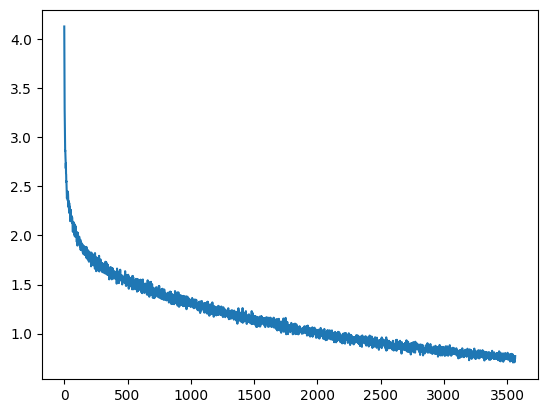

In [65]:
plt.plot(lossi)

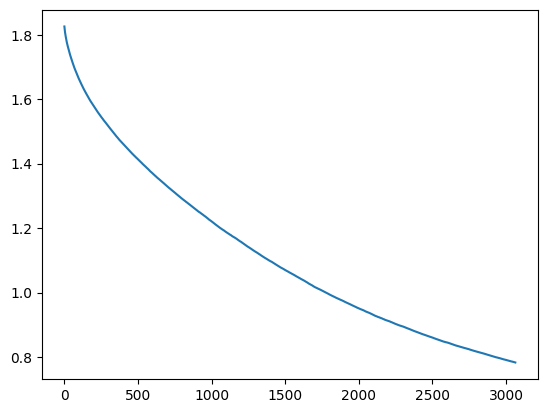

In [66]:
smoothed_losses = []
for i in range(0, len(lossi)):
    smoothed_losses.append(sum(lossi[i:i+500]) / 500)

plt.plot(smoothed_losses[:-500])
#

In [67]:
# save model weights
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimiser.state_dict(),
    "loss": loss
}, "checkpoint.pt")

In [68]:
# text generation
sequence_length = 128
@torch.no_grad()
def generate_text(model, start_text: str, length: int) -> str:
    if ' ' not in stoi:
        stoi[' '] = len(stoi)
    # encode the start text
    encoded_text = torch.tensor([stoi[letter] for letter in list(start_text)], dtype=torch.long)
    # generate the text
    for i in range(length):
        # get the next letter
        text = encoded_text[-sequence_length:]
        y_hat = model(text.unsqueeze(0))
        y_hat = y_hat.squeeze()[:, -1]
        y_hat = F.softmax(y_hat, dim=-1)
        # sample from the distribution
        next_letter = torch.multinomial(y_hat, 1)
        # add the letter to the encoded text
        encoded_text = torch.cat((encoded_text, next_letter))
    # decode the text
    decoded_text = "".join([itos[letter.item()] for letter in encoded_text])
    return decoded_text

In [70]:
new_model = model.eval()

# start text of length 128 characters
start_text = " " * 128
# generate text
generated_text = generate_text(new_model, start_text, 2000)
print(generated_text)

KeyError: ' '